# Implementing a Declarative Node using the `ddn.pytorch.node` Module

Unlike the previous tutorials, in this notebook we use the [PyTorch](https://pytorch.org/) framework to implement a declarative node. For information on how to use PyTorch, see the [official documentation](https://pytorch.org/docs/stable/index.html) and [tutorials](https://pytorch.org/tutorials/). Here we will show how to implement a declarative node using the `ddn.pytorch.node` module to explore the behavior of the node and solve simple bi-level optimization problems.

## Example 1: Minimize KL-divergence over the probability simplex

We consider the problem of minimizing the KL-divergence between the input $x$ and output $y$ subject to the output forming a valid probablility vector (i.e., the elements of $y$ be positive and sum to one). We will assume strictly positive $x$. The problem can be written formally as

$$
\begin{array}{rll}
y =& \text{argmin}_u & - \sum_{i=1}^{n} x_i \log u_i \\
& \text{subject to} & \sum_{i=1}^{n} u_i = 1
\end{array}
$$
where the positivity constraint on $y$ is automatically satisfied by the domain of the log function.

A nice feature of this problem is that we can solve it in closed-form as
$$
y = \frac{1}{\sum_{i=1}^{n} x_i} x.
$$

However, we will only use this for verification and pretend for now that we do not have a closed-form solution. Instead we will make use of the `scipy.optimize` module to solve the problem via an iterative method. Deriving our deep declarative node from the `LinEqConstDeclarativeNode` class, we will need to implement three functions: the `objective` function, the `solve` function, and the `linear_constraint_parameters` function (the `gradient` function is already implemented for us).


In [1]:
import torch
import numpy as np
import scipy.optimize as opt

import sys
sys.path.append("../")
from ddn.pytorch.node import *

# create the example node
class MinKL(LinEqConstDeclarativeNode):
    def __init__(self):
        super().__init__()

    def objective(self, x, y):
        return -1.0 * torch.einsum('bn,bn->b', (x, y.log()))
    
    def linear_constraint_parameters(self, y):
        """Ay=d"""
        A = y.new_ones(1, y.size(-1)) # 1xm
        d = y.new_ones(1) # 1
        return A, d
        
    def solve(self, x):
        # Solve the constrained optimization problem using scipy's built-in minimize function. Here we
        # initialize the solver at the uniform distribution.
        m = n = x.size(-1)
        u0 = np.ones((m,)) / m
        y = torch.zeros_like(x)
        # Loop over batch:
        for i, xi in enumerate(x):
            result = opt.minimize(lambda u: -1.0 * np.dot(xi.detach().numpy(), np.log(u)), u0,
                                  constraints={'type': 'eq', 'fun': lambda u: np.sum(u) - 1.0},
                                  bounds=opt.Bounds(1e-12, np.inf, keep_feasible=True),
                                  options={'maxiter': 100000, 'ftol': 1e-12})
            y[i, :] = torch.tensor(result.x)
        
        # The solve function must always return two arguments, the solution and context (i.e., cached values needed
        # for computing the gradient). In the case of linearly constrained problems we do not need the dual solution
        # in computing the gradient so we return None for context.
        return y, None

In [2]:
# test the node
node = MinKL()
x = torch.rand(1, 5)
print("Input:\n{}".format(x.squeeze().numpy()))
print("Expected output:\n{}".format((x / x.sum(dim=-1, keepdim=True)).squeeze().numpy()))

y, _ = node.solve(x)
print("Actual output:\n{}".format(y.squeeze().numpy()))

Input:
[0.600088   0.5238905  0.13237393 0.701075   0.7780055 ]
Expected output:
[0.21937586 0.19152012 0.04839231 0.25629398 0.28441766]
Actual output:
[0.21937585 0.19152017 0.04839228 0.25629398 0.28441772]


We now plot the function and gradient sweeping the first component of the input $x_1$ from 0.1 to 10.0 while holding the other elements of $x$ constant.

<IPython.core.display.Javascript object>


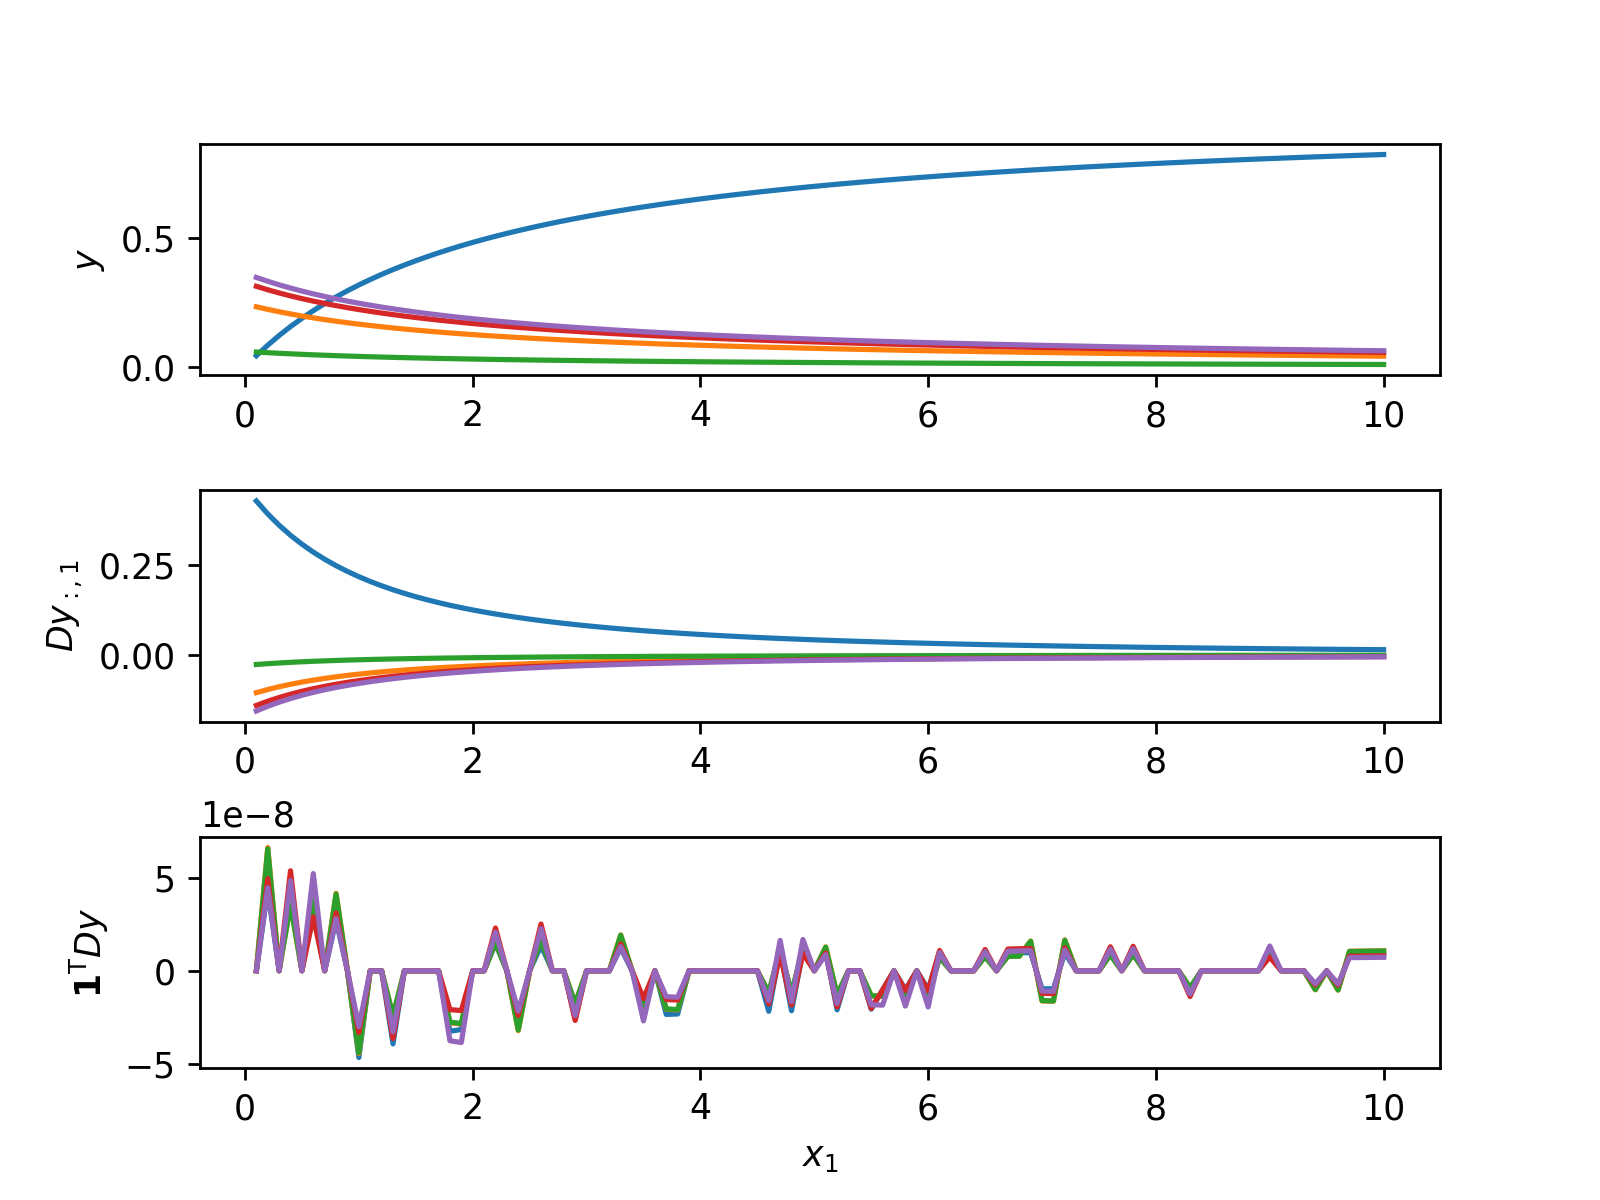

In [3]:
%matplotlib notebook
import matplotlib.pyplot as plt

x1_data = torch.linspace(0.1, 10.0, 100)
x = x.detach() # Don't track computation graph
y_data = []
Dy_data = []
vjp_data = []
for x1 in x1_data:
    x_new = x.clone()
    x_new[0, 0] = x1
    x_new.requires_grad = True
    y, _ = torch.no_grad()(node.solve)(x_new)
    y.requires_grad = True
    y_data.append(y.squeeze().detach().numpy())
    # Note that the jacobian function call is inefficient
    # and is used only for teaching and analysis purposes
    Dy_data.append(node.jacobian(x_new, y=y)[0][0,:,0].detach().numpy())
    vjp_data.append(node.gradient(x_new, y=y)[0][0,:].detach().numpy())
    
fig = plt.figure()
plt.subplot(3, 1, 1)
plt.plot(x1_data, y_data)
plt.ylabel(r"$y$")

plt.subplot(3, 1, 2)
plt.plot(x1_data, Dy_data)
plt.ylabel(r"$Dy_{:,1}$")

plt.subplot(3, 1, 3)
plt.plot(x1_data, vjp_data)
plt.xlabel(r"$x_1$"); plt.ylabel(r"$\mathbf{1}^\mathsf{T}Dy$")

fig.subplots_adjust(hspace=0.5)
plt.show()


### Bi-level optimization

Now let's see whether we can use the node within a bi-level optimization problem. We will attempt to learn an input $x$ that results in an output $y$ with smallest norm-squared. Moreover, we will regularize the norm of $x$ to be close to 10. Given our understanding of KL-divergence this should learn a vector $x$ that is a constant multiple of the ones vector (i.e., all elements of $x$ should be the same). Let's see what happens.

Found x = [3.7354755 4.3979545 4.4058223 5.416354  4.2374606] with norm 10.00
Results in y = [0.1683172  0.19816798 0.19852245 0.24405612 0.19093624]


<IPython.core.display.Javascript object>


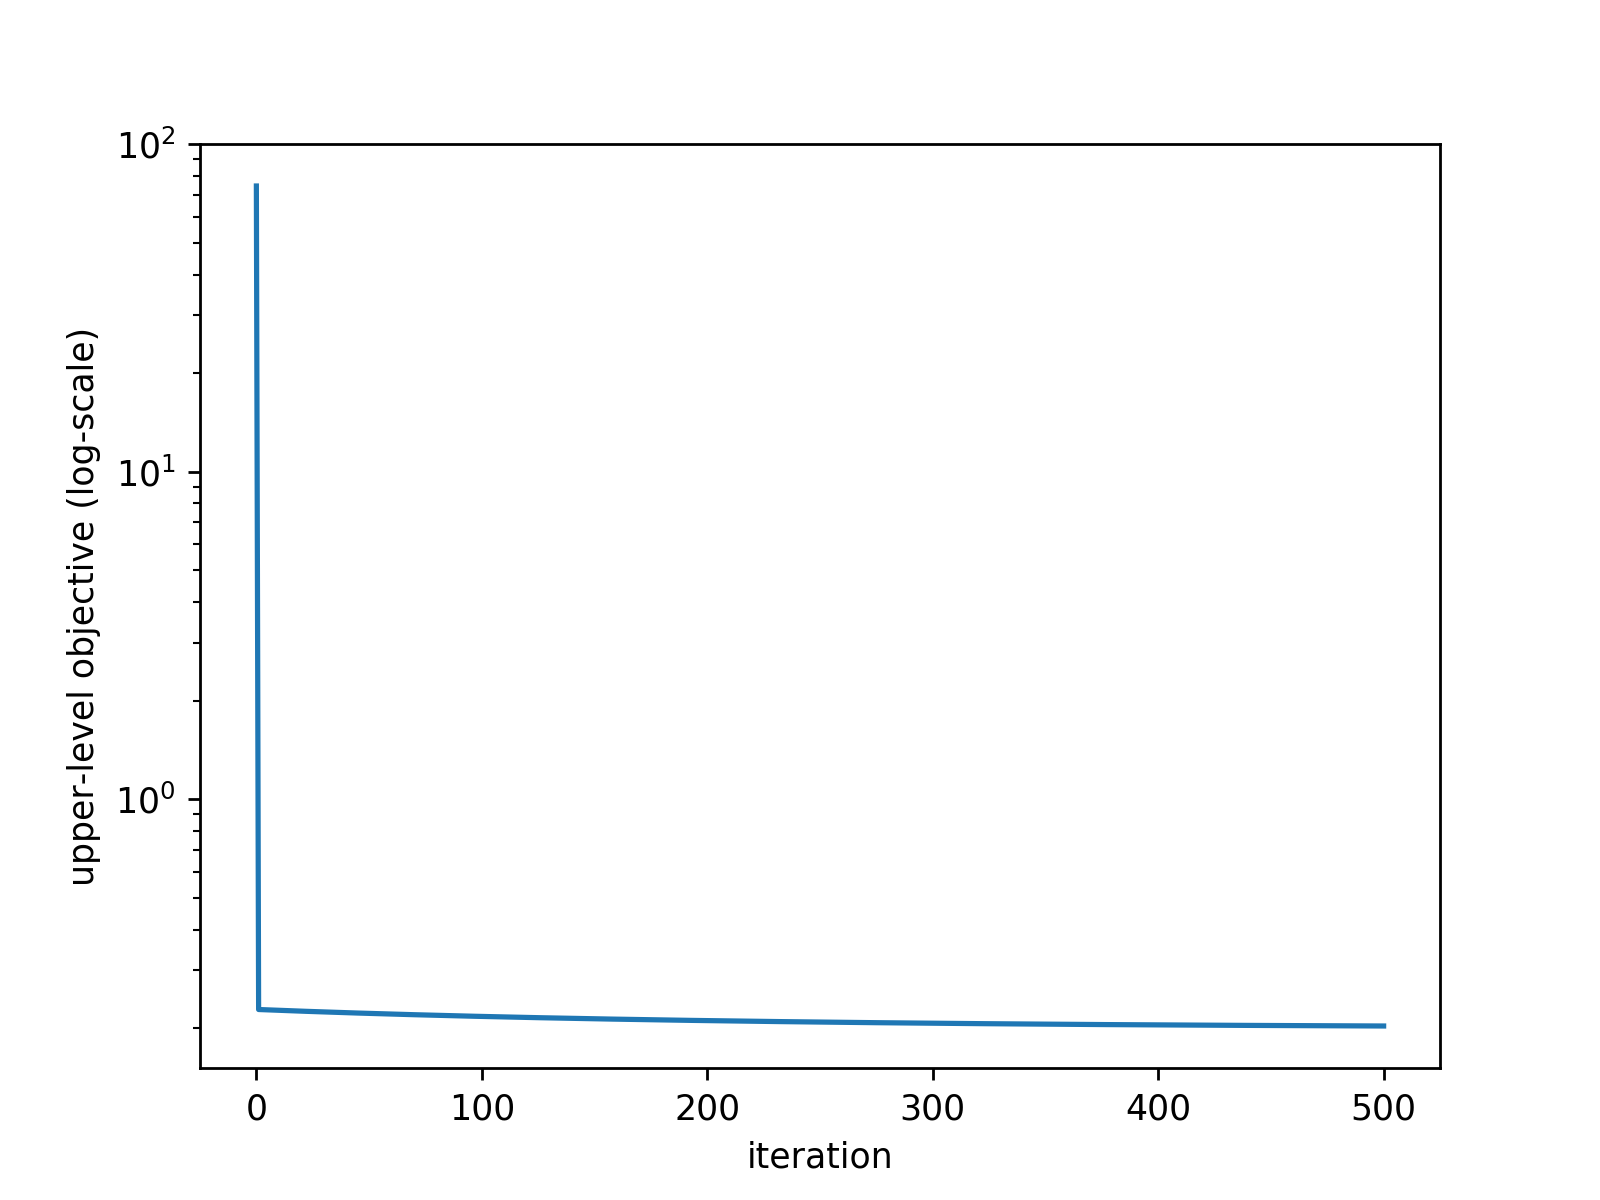

Found x = [4.4721437 4.4721346 4.472141  4.4721336 4.4721355] with norm 10.00
Results in y = [0.2000003  0.19999985 0.20000015 0.1999998  0.1999999 ]


<IPython.core.display.Javascript object>


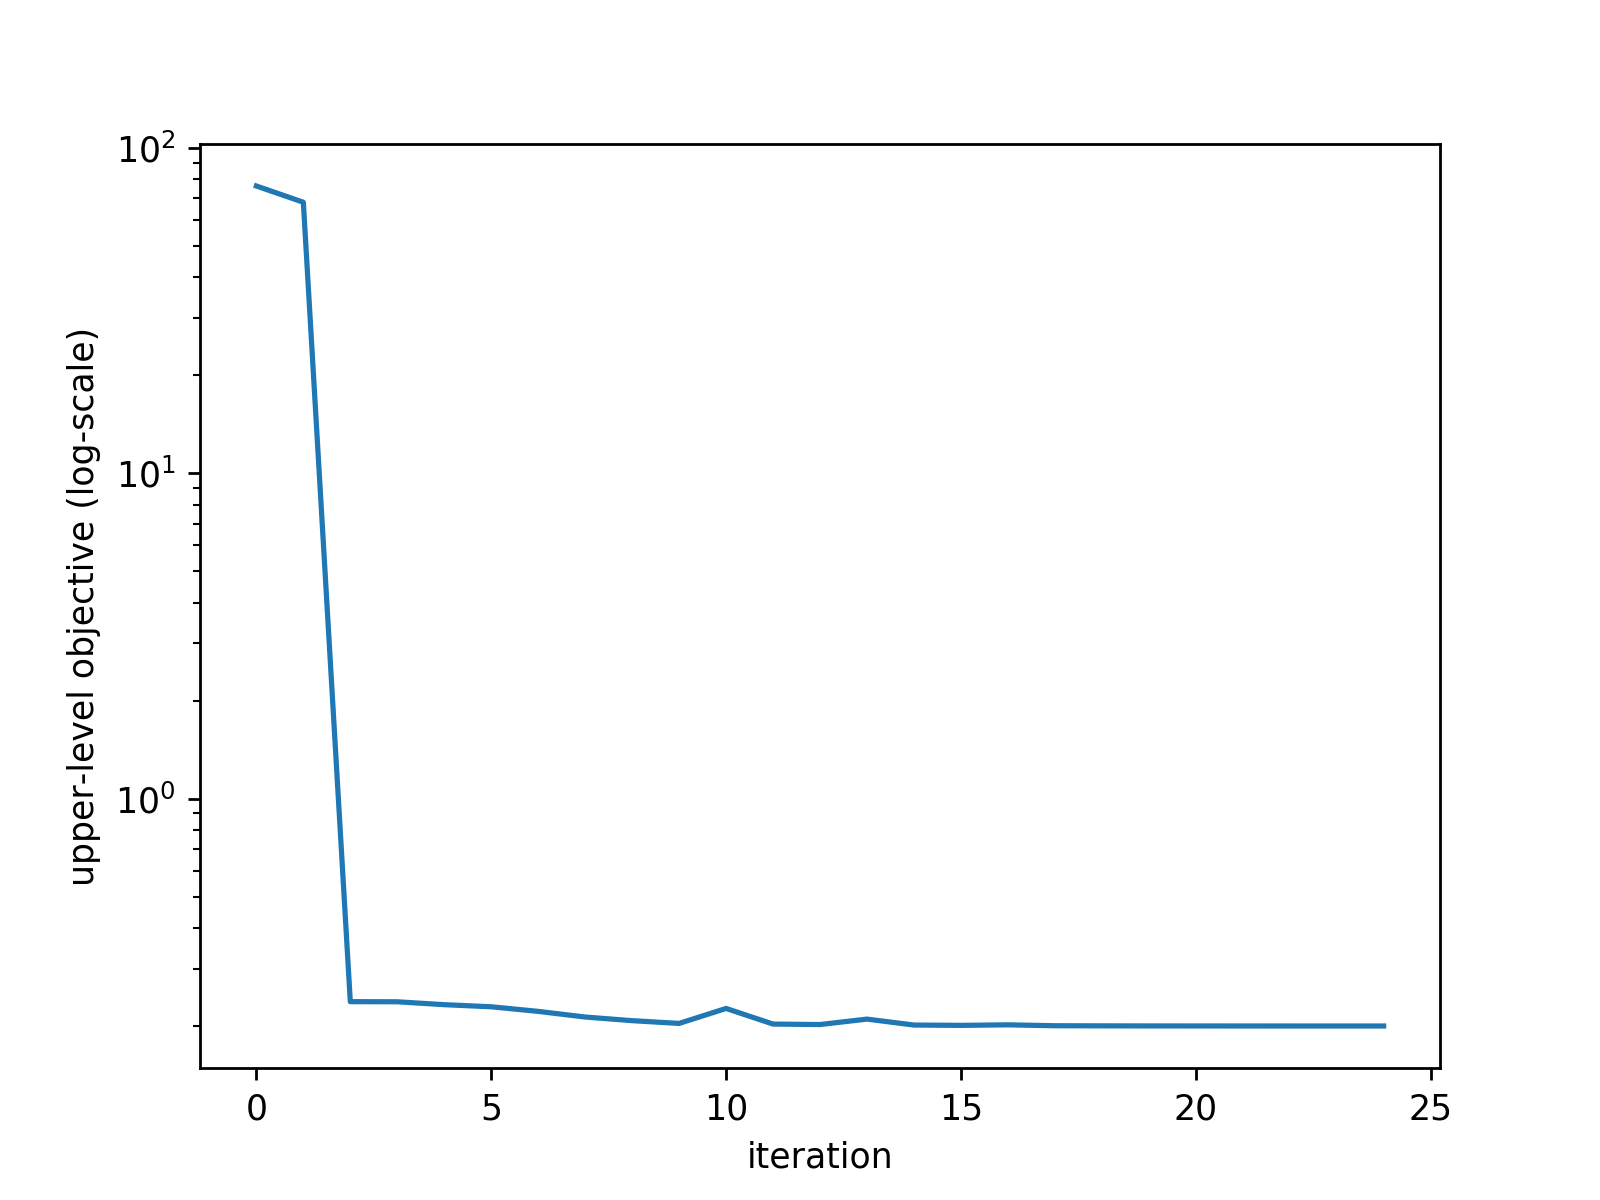

In [4]:
# define the upper-level objective
def J(x, y=None):
    """Computes our upper-level objective given both x and y."""
    if y is None:
        y, _ = torch.no_grad()(node.solve)(x)
    return ((y.norm(dim=-1)) ** 2 + (x.norm(dim=-1) - 10.0) ** 2).mean()

kl_problem = MinKL()
kl_declarative_layer = DeclarativeLayer(kl_problem)

# Solve using gradient descent:
learning_rate = 0.5
x = torch.rand(1, 5, requires_grad=True)
history = [J(x)]
for i in range(500):
    y = kl_declarative_layer(x)
    z = J(x, y)
    z.backward()
    x_new = x - learning_rate * x.grad
    x = x_new.detach().requires_grad_(True)
    history.append(J(x))

y, _ = torch.no_grad()(node.solve)(x)
x_np = x.detach().squeeze().numpy()
y_np = y.detach().squeeze().numpy()
print("Found x = {} with norm {:0.2f}".format(x_np, np.sqrt(np.dot(x_np, x_np))))
print("Results in y = {}".format(y_np))

fig = plt.figure()
plt.semilogy(history)
plt.ylabel("upper-level objective (log-scale)"); plt.xlabel("iteration")
plt.show()

# Solve using LBFGS:
x = torch.rand(1, 5, requires_grad=True)
history = []
optimizer = torch.optim.LBFGS([x], lr=1, max_iter=100)
def reevaluate():
    optimizer.zero_grad()
    y = kl_declarative_layer(x)
    z = J(x, y)
    z.backward()
    history.append(z.clone())
    return z
optimizer.step(reevaluate)

y, _ = torch.no_grad()(node.solve)(x)
x_np = x.detach().squeeze().numpy()
y_np = y.detach().squeeze().numpy()
print("Found x = {} with norm {:0.2f}".format(x_np, np.sqrt(np.dot(x_np, x_np))))
print("Results in y = {}".format(y_np))

fig = plt.figure()
plt.semilogy(history)
plt.ylabel("upper-level objective (log-scale)"); plt.xlabel("iteration")
plt.show()

## Example 2: Minimize robust (pseudo-Huber) distance

We consider the problem of minimizing the distance between the input $x$ and output $y$ using the robust pseudo-Huber penalty function. The problem can be written formally as
$$
\begin{equation}
y = \text{argmin}_u \sum_{i=1}^{n} \phi^\text{pseudo}(u - x_i; \alpha)
\end{equation}
$$
where the pseudo-Huber penalty function is given by
$$
\begin{equation}
  \phi^{\text{pseudo}}(z; \alpha) = \alpha^2 \left( \sqrt{1 + \left(\frac{z}{\alpha}\right)^2} - 1 \right).
\end{equation}
$$

Deriving our deep declarative node from the `AbstractDeclarativeNode` class, we will need to implement two functions: the `objective` function, and the `solve` function. However, we will also provide a `gradient` function to compare the generic gradient result with an efficient hand-coded gradient that makes use of the structure of the problem.

In [5]:
import torch
import numpy as np
import scipy.optimize as opt

import sys
sys.path.append("../")
from ddn.pytorch.node import *

#import warnings
#warnings.filterwarnings('ignore')

class GlobalPseudoHuberPool2d(AbstractDeclarativeNode):
    """"""
    def __init__(self):
        super().__init__()
        
    def objective(self, x, alpha, y):
        alpha2 = alpha * alpha
        z = y.unsqueeze(-1).unsqueeze(-1) - x
        phi = alpha2 * (torch.sqrt(1.0 + torch.pow(z, 2) / alpha2) - 1.0)
        return phi.sum(dim=(-2,-1)) # b

    def runOptimisation(self, x, alpha, y):
        with torch.enable_grad():
            opt = torch.optim.LBFGS([y],
                                    lr=1, # Default: 1
                                    max_iter=100, # Default: 20
                                    max_eval=None, # Default: None
                                    tolerance_grad=1e-05, # Default: 1e-05
                                    tolerance_change=1e-09, # Default: 1e-09
                                    history_size=100, # Default: 100
                                    line_search_fn=None # Default: None, Alternative: "strong_wolfe"
                                    )
            def reevaluate():
                opt.zero_grad()
                f = self.objective(x, alpha, y).sum() # sum over batch elements
                f.backward()
                return f
            opt.step(reevaluate)
        return y

    def solve(self, x, alpha):
        x = x.detach()
        y = x.mean([-2, -1]).clone().requires_grad_()
        y = self.runOptimisation(x, alpha, y)
        y = y.detach()
        z = (y.unsqueeze(-1).unsqueeze(-1) - x).clone()
        ctx = {'z': z}
        return y, ctx

    def gradient(self, x, alpha, y=None, v=None, ctx=None):
        """Override base class to compute the analytic gradient of the optimal solution."""
        if y is None:
            y, ctx = torch.no_grad()(self.solve)(x, alpha)
        if v is None:
            v = torch.ones_like(y)
        z = ctx['z'] # b x n1 x n2
        w = torch.pow(1.0 + torch.pow(z, 2) / (alpha * alpha), -1.5)
        w_sum = w.sum(dim=-1, keepdim=True).sum(dim=-2, keepdim=True).expand_as(w)
        Dy_at_x = torch.where(w_sum.abs() <= 1e-9, torch.zeros_like(w), w.div(w_sum))  # b x n1 x n2
        return torch.einsum('b,bmn->bmn', (v, Dy_at_x)), None

In [6]:
# test the node
node = GlobalPseudoHuberPool2d()
batch_size = 3
input_size = (6, 6)
x = torch.randn(batch_size, *input_size, dtype=torch.double, requires_grad=True)
alpha = torch.tensor([0.5], dtype=torch.double, requires_grad=False)
y, _ = torch.no_grad()(node.solve)(x, alpha)

print("Input:\n{}".format(x[0,...].squeeze().detach().numpy())) # First batch element only
print("Output:\n{}".format(y[0,...].squeeze().detach().numpy())) # First batch element only

Input:
[[-1.32708517  0.52615032 -0.37203926  1.94706176  0.25736788 -0.37597948]
 [-1.01797427  0.13593073 -0.05666012  0.9721196  -0.36122323  1.12630977]
 [ 0.5729672   1.10779523 -0.92016142 -0.0846731  -0.17847644 -1.10934522]
 [-0.02452702  0.74503531 -1.61700144 -0.24112337 -0.01022458  0.80187339]
 [-1.14428778  0.43972123 -0.23475191 -0.96107802 -0.70309833 -0.75949966]
 [ 1.91284768  0.20689302 -0.79440886  0.18841139  0.0332241  -0.25251987]]
Output:
-0.08616878567920183


We now plot the function and gradient sweeping the first component of the input $x_1$ from -10.0 to 10.0 while holding the other elements of $x$ constant.

<IPython.core.display.Javascript object>


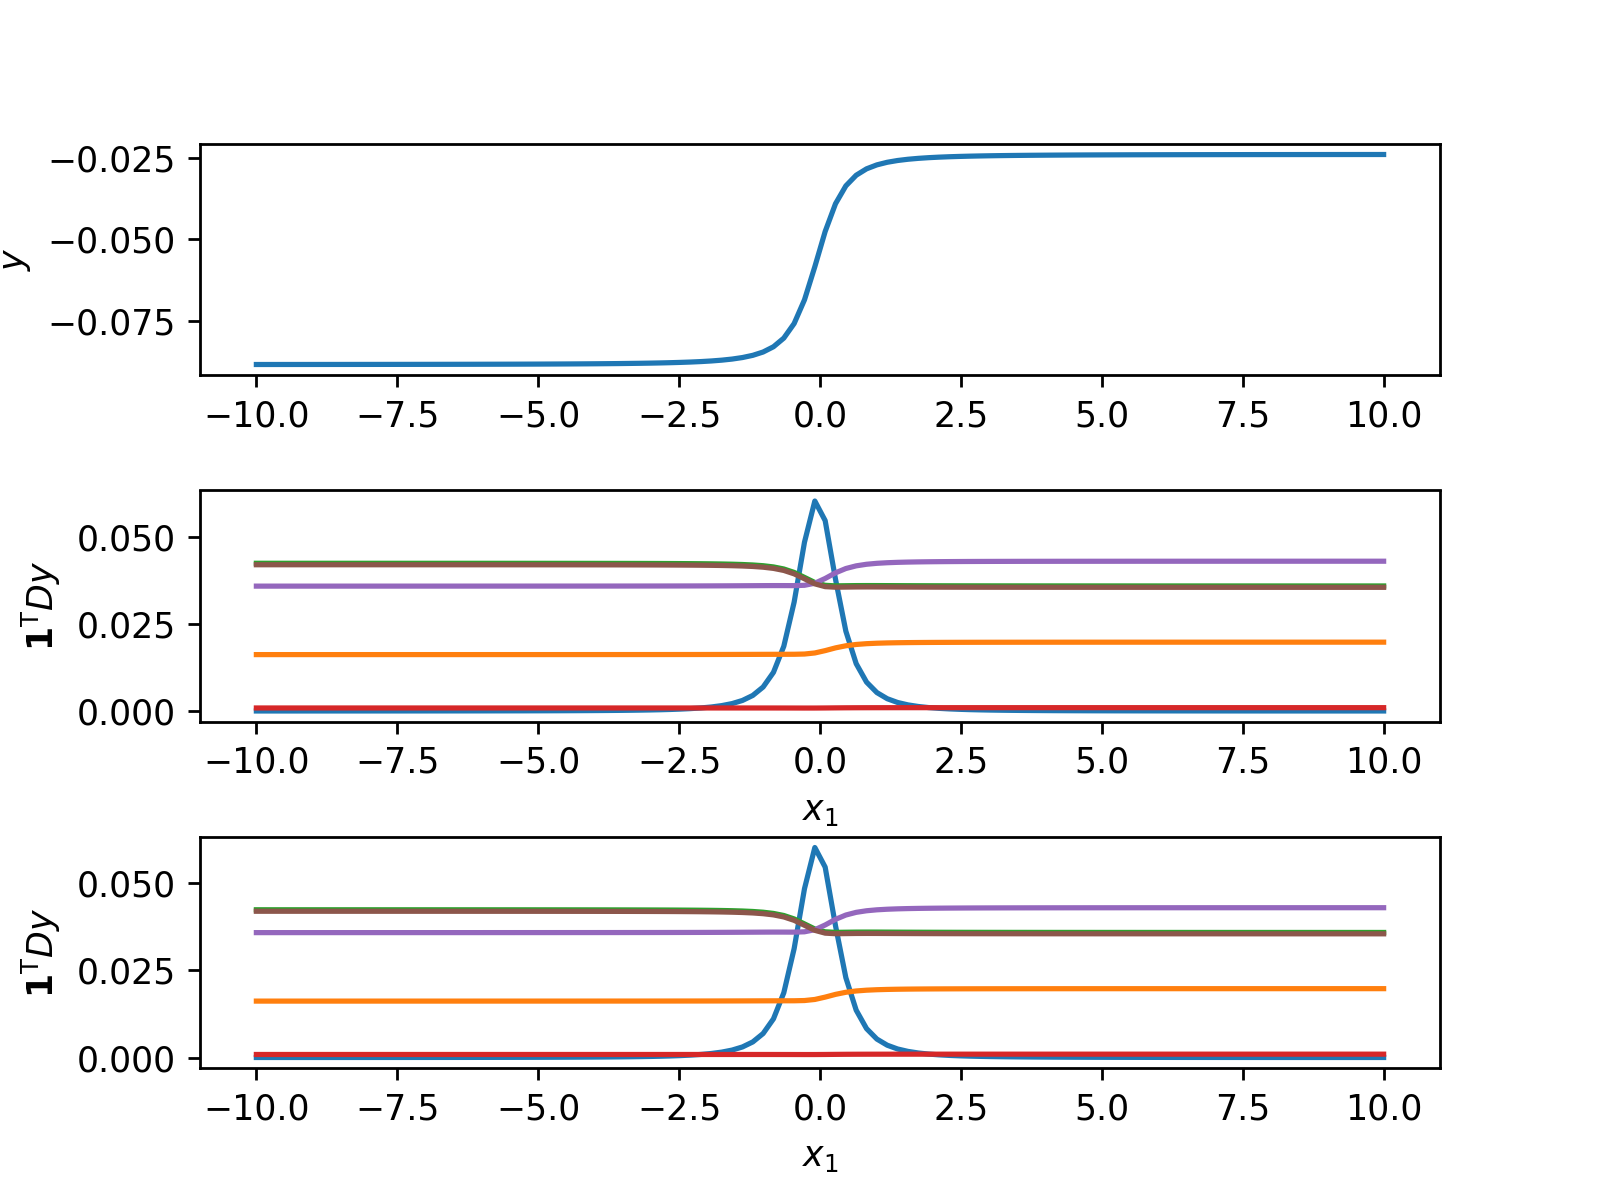

In [7]:
%matplotlib notebook
import matplotlib.pyplot as plt

x1_data = torch.linspace(-10.0, 10.0, 110)
x = x.detach() # Don't track computation graph
y_data = []
vjp_data = []
vjp2_data = []
for x1 in x1_data:
    x_new = x.clone()
    x_new[:, 0, 0] = x1
    x_new.requires_grad = True
    y, ctx = torch.no_grad()(node.solve)(x_new, alpha)
    y.requires_grad = True
    y_data.append(y[0,...].squeeze().detach().numpy()) # First batch element only
    vjp_data.append(super(type(node), node).gradient(x_new, alpha, y=y, ctx=ctx)[0][0,0,:].detach().numpy()) # First 6 components
    vjp2_data.append(node.gradient(x_new, alpha, y=y, ctx=ctx)[0][0,0,:].detach().numpy()) # First 6 components
    
fig = plt.figure()
plt.subplot(3, 1, 1)
plt.plot(x1_data, y_data)
plt.ylabel(r"$y$")

plt.subplot(3, 1, 2)
plt.plot(x1_data, vjp_data)
plt.xlabel(r"$x_1$"); plt.ylabel(r"$\mathbf{1}^\mathsf{T}Dy$")

plt.subplot(3, 1, 3)
plt.plot(x1_data, vjp2_data)
plt.xlabel(r"$x_1$"); plt.ylabel(r"$\mathbf{1}^\mathsf{T}Dy$")

fig.subplots_adjust(hspace=0.5)
plt.show()
